In [236]:
import numpy as np
import pandas as pd
import pickle
# from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout, GlobalMaxPooling1D
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [237]:
def loadFromPickle(pickleFile):
    file = open(pickleFile,'rb')
    pickleData = pickle.load(file)
    file.close()
    return pickleData

In [238]:
df = pd.read_csv("../input/hasoc2019/hasoc2019_hi_test_gold_2919.tsv",sep='\t')
df.head()

x_test = np.array(df['text'])
y_test_true = np.array(df['task_1'])
y_test_true.shape

df = pd.read_csv("../input/hasoc2019/hindi_dataset.tsv",sep='\t')
y_train_true = np.array(df['task_1'])
y_train_true.shape

(4665,)

In [239]:
tv = []
tv.append(loadFromPickle('../input/sentence-vectors/inltk_sentence_vectors_1000'))
tv.append(loadFromPickle('../input/sentence-vectors/inltk_sentence_vectors_2000'))
tv.append(loadFromPickle('../input/sentence-vectors/inltk_sentence_vectors_4000'))
tv.append(loadFromPickle('../input/sentence-vectors/inltk_sentence_vectors_4665'))

print(len(tv[3]))
train_data = []
y_val = []
for i in range(len(tv)):
    for j in list(tv[i].keys()):
        train_data.append(tv[i][j][0])
        y_val.append(j)
        
print(len(train_data), len(y_val))
y_train = y_train_true[y_val]
print(len(y_train))
for i in range(len(y_train)):
    if y_train[i]=='NOT':
        y_train[i] = 0
    else:
        y_train[i] = 1
print(y_train)
y_train = np.asarray(y_train).astype(np.float64)
print(type(y_train[0]))

640
4377 4377
4377
[0 1 1 ... 0 1 1]
<class 'numpy.float64'>


In [240]:
test_vectors = loadFromPickle('../input/sentence-vectors/inltk_test_sentence_vectors')
y_test = y_test_true[list(test_vectors.keys())]
print(len(test_vectors.keys()))
print(len(y_test))
for i in range(len(y_test)):
    if y_test[i]=='NOT':
        y_test[i] = 0
    else:
        y_test[i] = 1
y_test = np.asarray(y_test).astype(np.float64)

1288
1288


In [241]:
print(len(test_vectors[0][0]))
data = []
for i in list(test_vectors.keys()):
    data.append(test_vectors[i][0])

print(len(data), len(data[0]))

400
1288 400


In [242]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=10)
trainX = np.array(train_data)
nanIndexes = list(set(np.where(np.isnan(trainX))[0].tolist()))
trainX = trainX[list(set(range(len(trainX))) - set(nanIndexes))]
y_train = y_train[list(set(range(len(y_train))) - set(nanIndexes))]
print(trainX.shape)
# trainX_pca = pca.fit_transform(trainX)

testX = np.array(data)

(4375, 400)


In [243]:
print(y_train.shape)

(4375,)


In [244]:
print(trainX.shape)
trainX = np.reshape(trainX, (trainX.shape[0],1, trainX.shape[1]))
print(trainX.shape)

# testX = np.array(data)
print(testX.shape)
# testX = np.array(scaler.fit_transform(testX))
testX = np.reshape(testX, (testX.shape[0],1, testX.shape[1]))
print(testX.shape)

(4375, 400)
(4375, 1, 400)
(1288, 400)
(1288, 1, 400)


In [245]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [246]:
## ref : keras documentation
def cnnModel(xTrain, yTrain, xTest, yTest):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(1, xTrain.shape[2])))
    model.add(Conv1D(filters=32, kernel_size=1, activation='relu'))
#     model.add(Conv1D(filters=32, kernel_size=1, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense( 1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m])

    #     print(model.summary())
    model.fit(xTrain, yTrain, epochs=50, verbose=1, batch_size=16)
    train_loss, train_accuracy, train_f1_score, train_precision, train_recall = model.evaluate(xTrain,  yTrain, verbose=0)
    test_loss, test_accuracy, test_f1_score, test_precision, test_recall = model.evaluate(xTest,  yTest, verbose=0)
    print("Train :",train_loss, train_accuracy, train_f1_score, train_precision, train_recall)
    print("Test :",test_loss, test_accuracy, test_f1_score, test_precision, test_recall)
    return model

In [1]:
## ref : keras documentation
def DenseModel(xTrain, yTrain, xTest, yTest):
    model = Sequential()
    model.add(Dense(units=20,input_shape=(1, 300))) #hidden layer 1 with input

    #further layers:    
    model.add(Dense(units=10, activation='relu'))
    model.add(Dense(units=5, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid')) #output layer 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m])

    #     print(model.summary())
    model.fit(xTrain, yTrain, epochs=50, verbose=0, batch_size=16)
    train_loss, train_accuracy, train_f1_score, train_precision, train_recall = model.evaluate(xTrain,  yTrain, verbose=0)
    test_loss, test_accuracy, test_f1_score, test_precision, test_recall = model.evaluate(xTest,  yTest, verbose=0)
    print("Train :",train_loss, train_accuracy, train_f1_score, train_precision, train_recall)
    print("Test :",test_loss, test_accuracy, test_f1_score, test_precision, test_recall)
    return model

In [248]:
cnn_ulm_model = cnnModel(trainX, y_train, testX, y_test) 


Epoch 1/50
274/274 [==============================] - 0s 2ms/step - loss: 0.6591 - accuracy: 0.6075 - f1_m: 0.6792 - precision_m: 0.6170 - recall_m: 0.8185
Epoch 2/50
274/274 [==============================] - 0s 2ms/step - loss: 0.5633 - accuracy: 0.7154 - f1_m: 0.7296 - precision_m: 0.7402 - recall_m: 0.7592
Epoch 3/50
274/274 [==============================] - 0s 2ms/step - loss: 0.5512 - accuracy: 0.7195 - f1_m: 0.7258 - precision_m: 0.7557 - recall_m: 0.7473
Epoch 4/50
274/274 [==============================] - 0s 2ms/step - loss: 0.4978 - accuracy: 0.7573 - f1_m: 0.7733 - precision_m: 0.7751 - recall_m: 0.7991
Epoch 5/50
274/274 [==============================] - 0s 2ms/step - loss: 0.4897 - accuracy: 0.7655 - f1_m: 0.7757 - precision_m: 0.7938 - recall_m: 0.7960
Epoch 6/50
274/274 [==============================] - 0s 2ms/step - loss: 0.4803 - accuracy: 0.7682 - f1_m: 0.7784 - precision_m: 0.7851 - recall_m: 0.8064
Epoch 7/50
274/274 [==============================] - 0s 2ms/ste

In [249]:
predictions = []
y_pred = cnn_ulm_model.predict(testX)
# y_pred =  (y_pred > 0.5).astype(int)
y_pred = [0 if i<.5 else 1 for i in y_pred]
predictions.append(y_pred)

In [251]:
# y_pred

In [2]:
## ref : keras documentation
def lstmModel(xTrain, yTrain, xTest, yTest):
    model = Sequential()
    model.add(LSTM(15, input_shape=( 1, xTrain.shape[2]),activation='sigmoid',return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(12))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m])

    #     print(model.summary())
    model.fit(xTrain, yTrain, epochs=50, verbose=0, batch_size=16)
    train_loss, train_accuracy, train_f1_score, train_precision, train_recall = model.evaluate(xTrain,  yTrain, verbose=0)
    test_loss, test_accuracy, test_f1_score, test_precision, test_recall = model.evaluate(xTest,  yTest, verbose=0)
    print("Train :",train_loss, train_accuracy, train_f1_score, train_precision, train_recall)
    print("Test :",test_loss, test_accuracy, test_f1_score, test_precision, test_recall)
    return model

In [254]:
lstm_ulm_model = lstmModel(trainX, y_train, testX, y_test)

Train : 0.41339361667633057 0.7933714389801025 0.7905644178390503 0.7563175559043884 0.8712905049324036
Test : 0.5055256485939026 0.7305900454521179 0.7352601289749146 0.6813206076622009 0.8092216849327087


In [255]:
y_pred = lstm_ulm_model.predict(testX)
# y_pred =  (y_pred > 0.5).astype(int)
y_pred = [0 if i<.5 else 1 for i in y_pred]
predictions.append(y_pred)
print(len(predictions), len(predictions[0]), len(predictions[1]))

2 1288 1288


# FastText

In [256]:
file_name ="../input/fasttextembeddings/embedd_labels_fasttext.npz"
loaded = np.load(file_name)
X_train = loaded["X_train"]
X_test = loaded["X_test"]
Y_train = loaded["Y_train"]
Y_test = loaded["Y_test"]

In [257]:
print(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape)
X_train = np.reshape(X_train, (X_train.shape[0],1, X_train.shape[1]))
print(X_train.shape)

X_test = np.reshape(X_test, (X_test.shape[0],1, X_test.shape[1]))
print(X_test.shape)

(4665, 300) (4665,) (1318, 300) (1318,)
(4665, 1, 300)
(1318, 1, 300)


In [258]:
cnn_fastext_model = cnnModel(X_train, Y_train, X_test, Y_test) 

Epoch 1/50
292/292 [==============================] - 0s 2ms/step - loss: 0.6106 - accuracy: 0.6907 - f1_m: 0.6877 - precision_m: 0.7006 - recall_m: 0.7114
Epoch 2/50
292/292 [==============================] - 1s 2ms/step - loss: 0.4766 - accuracy: 0.7758 - f1_m: 0.7734 - precision_m: 0.7976 - recall_m: 0.7780
Epoch 3/50
292/292 [==============================] - 0s 2ms/step - loss: 0.4449 - accuracy: 0.7983 - f1_m: 0.7922 - precision_m: 0.8295 - recall_m: 0.7843
Epoch 4/50
292/292 [==============================] - 1s 2ms/step - loss: 0.4292 - accuracy: 0.8047 - f1_m: 0.8018 - precision_m: 0.8243 - recall_m: 0.8044
Epoch 5/50
292/292 [==============================] - 1s 2ms/step - loss: 0.4119 - accuracy: 0.8105 - f1_m: 0.8081 - precision_m: 0.8331 - recall_m: 0.8082
Epoch 6/50
292/292 [==============================] - 1s 2ms/step - loss: 0.4038 - accuracy: 0.8137 - f1_m: 0.8067 - precision_m: 0.8350 - recall_m: 0.8066
Epoch 7/50
292/292 [==============================] - 1s 2ms/ste

In [260]:
y_pred = cnn_fastext_model.predict(X_test)
# y_pred =  (y_pred > 0.5).astype(int)
y_pred = [0 if i<.5 else 1 for i in y_pred]

# print(len(predictions), len(predictions[0]), len(predictions[1]), len(predictions[2]))

In [261]:
predictions.append(y_pred)
print(len(predictions), len(predictions[0]), len(predictions[1]), len(predictions[2]))


3 1288 1288 1318


In [262]:
lstm_fastext_model = lstmModel(X_train, Y_train, X_test, Y_test)

Train : 0.4127492606639862 0.8002143502235413 0.7913225889205933 0.7999027371406555 0.8265913724899292
Test : 0.4523051977157593 0.7890743613243103 0.770104706287384 0.7562322020530701 0.7961184978485107


In [266]:
y_pred = lstm_fastext_model.predict(X_test)
# y_pred =  (y_pred > 0.5).astype(int)
y_pred = [0 if i<.5 else 1 for i in y_pred]
predictions.append(y_pred)


In [267]:
print(len(predictions), len(predictions[0]), len(predictions[1]), len(predictions[2]), len(predictions[3]))


4 1288 1288 1318 1318


In [273]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.svm import LinearSVC

In [292]:
model_names = ['cnn_ulm_model', 'lstm_ulm_model', 'cnn_fasttext_model', 'lstm_fasttext_model']
models = [cnn_ulm_model, lstm_ulm_model, cnn_fastext_model, lstm_fastext_model]
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc', 'p', 'r', 'acc', 'f1'])
# list(test_vectors.keys())
# for model in models:

y_prob = cnn_ulm_model.predict_proba(testX)[::,0]
# print(y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)
precision = precision_score(predictions[0], y_test)
recall = recall_score(predictions[0], y_test)
fscore = f1_score(predictions[0], y_test)
print("auc :" ,auc )
print("precision :", precision)
print("recall :", recall)
print("f_score :", fscore )
result_table = result_table.append({'classifiers':'cnn_ulm_model',
                                    'fpr':fpr, 
                                    'tpr':tpr, 
                                    'auc':auc,
                                    'p': precision,
                                    'r': recall,
                                    'acc' :acc,
                                    'f1': fscore}, ignore_index=True)

auc : 0.8384387112403101
precision : 0.8066666666666666
recall : 0.6964028776978417
f_score : 0.7474903474903475


In [293]:
y_prob = lstm_ulm_model.predict_proba(testX)[::,0]
# print(y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)
precision = precision_score(predictions[1], y_test)
recall = recall_score(predictions[1], y_test)
fscore = f1_score(predictions[1], y_test)
print("auc :" ,auc )
print("precision :", precision)
print("recall :", recall)
print("f_score :", fscore )
result_table = result_table.append({'classifiers':'lstm_ulm_model',
                                    'fpr':fpr, 
                                    'tpr':tpr, 
                                    'auc':auc,
                                    'p': precision,
                                    'r': recall,
                                    'acc' :acc,
                                    'f1': fscore}, ignore_index=True)

auc : 0.8400048449612403
precision : 0.8116666666666666
recall : 0.6754507628294036
f_score : 0.7373202119606359


In [294]:
y_prob = cnn_fastext_model.predict_proba(X_test)[::,0]
# print(y_prob)
fpr, tpr, _ = roc_curve(Y_test, y_prob)
auc = roc_auc_score(Y_test, y_prob)
precision = precision_score(predictions[2], Y_test)
recall = recall_score(predictions[2], Y_test)
fscore = f1_score(predictions[2], Y_test)
print("auc :" ,auc )
print("precision :", precision)
print("recall :", recall)
print("f_score :", fscore )
result_table = result_table.append({'classifiers':'cnn_fastext_model',
                                    'fpr':fpr, 
                                    'tpr':tpr, 
                                    'auc':auc,
                                    'p': precision,
                                    'r': recall,
                                    'acc' :acc,
                                    'f1': fscore}, ignore_index=True)

auc : 0.873116734088301
precision : 0.8413223140495868
recall : 0.7128851540616247
f_score : 0.7717968157695224


In [295]:
y_prob = lstm_fastext_model.predict_proba(X_test)[::,0]
# print(y_prob)
fpr, tpr, _ = roc_curve(Y_test, y_prob)
auc = roc_auc_score(Y_test, y_prob)
precision = precision_score(predictions[3], Y_test)
recall = recall_score(predictions[3], Y_test)
fscore = f1_score(predictions[3], Y_test)
print("auc :" ,auc )
print("precision :", precision)
print("recall :", recall)
print("f_score :", fscore )
result_table = result_table.append({'classifiers':'lstm_fastext_model',
                                    'fpr':fpr, 
                                    'tpr':tpr, 
                                    'auc':auc,
                                    'p': precision,
                                    'r': recall,
                                    'acc' :acc,
                                    'f1': fscore}, ignore_index=True)

auc : 0.8776140855192238
precision : 0.7983471074380165
recall : 0.755868544600939
f_score : 0.7765273311897107


In [296]:
result_table.set_index('classifiers', inplace=True)

In [297]:
result_table

,fpr,tpr,auc,p,r,acc,f1
classifiers,,,,,,,
cnn_ulm_model,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.002906976744186046...","[0.0, 0.0016666666666666668, 0.026666666666666...",0.838439,0.806667,0.696403,"(0.7465142607688904, 0.72826087474823)",0.747490
lstm_ulm_model,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.001453488372093023...","[0.0, 0.0016666666666666668, 0.011666666666666...",0.840005,0.811667,0.675451,"(0.7465142607688904, 0.72826087474823)",0.737320
cnn_fastext_model,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0014025245441...","[0.0, 0.01487603305785124, 0.01818181818181818...",0.873117,0.841322,0.712885,"(0.7465142607688904, 0.72826087474823)",0.771797
lstm_fastext_model,"[0.0, 0.0, 0.0, 0.001402524544179523, 0.001402...","[0.0, 0.001652892561983471, 0.1140495867768595...",0.877614,0.798347,0.755869,"(0.7465142607688904, 0.72826087474823)",0.776527


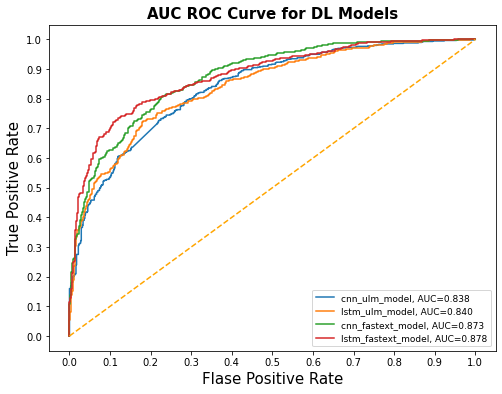

In [299]:
## ref : stackoverflow graph tutorial
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('AUC ROC Curve for DL Models', fontweight='bold', fontsize=15)
plt.legend(prop={'size':9}, loc='lower right')

plt.show()